# Mushroom Classification


### Data Set

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be" for Poisonous Oak and Ivy. Our goal is to train a machine learning model that is able to predicts whether a mushroom is poisonous. The complete data set can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/Mushroom).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder

from collections import Counter

In [2]:
sns.set()
df = pd.read_csv('mushrooms.csv')

### Analysis

#### Pie chart
  - Show the distribution of classes
  - Check whether the data set is balanced

In [3]:
count_p = df.groupby('class')['class'].count()['p']
count_e = df.groupby('class')['class'].count()['e']

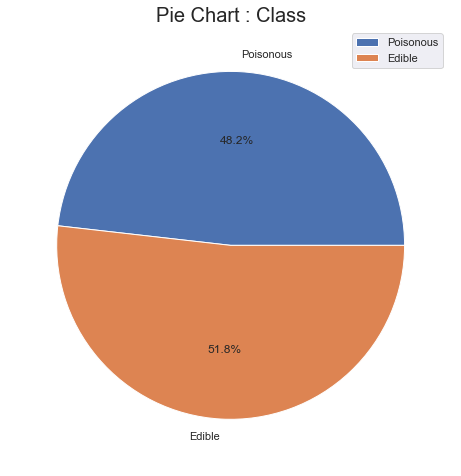

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
labels = ['Poisonous','Edible']
patches, _, _ = ax.pie([count_p, count_e], labels=labels,autopct='%1.1f%%')
plt.legend(patches, labels, loc="best")
plt.title("Pie Chart : Class", fontsize=20)
plt.show()

 - From the chart above, we can see that the data set is pretty balanced.

---

#### Violin Plot
  - Show the distribution of every feature
  - Identify well-typed features
  - Identify highly correleated or redundant features
  
credit to https://www.kaggle.com/haimfeld87/analysis-and-classification-of-mushrooms

In [5]:
df_labeled = df.copy()

In [6]:
labelencoder=LabelEncoder()
for column in df_labeled.columns:
    df_labeled[column] = labelencoder.fit_transform(df_labeled[column])

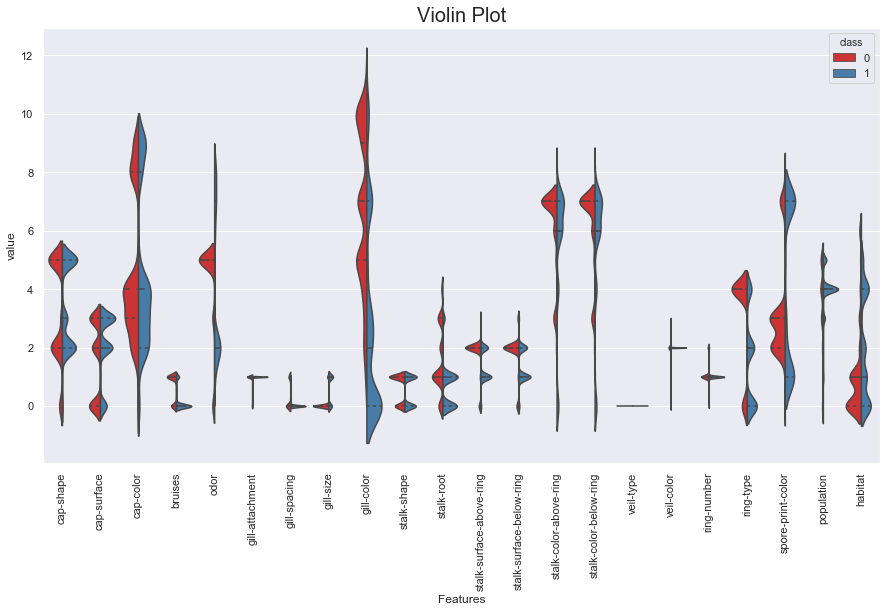

In [7]:
df_labeled_div = pd.melt(df_labeled, "class", var_name="Features")
fig, ax = plt.subplots(figsize=(15,8))
p = sns.violinplot(ax = ax, x="Features", y="value", hue="class",split = True, data=df_labeled_div, inner = 'quartile', palette = 'Set1')
df_labeled_no_class = df_labeled.drop(["class"], axis = 1)
p.set_xticklabels(rotation = 90, labels = list(df_labeled_no_class.columns))
plt.title("Violin Plot", fontsize=20)
plt.show()

 - The feature "veil-type" is well-typed (i.e. there is only one unique value for that feature), hence we can remove it.
 - The shape of "stalk-surface-below-ring" and "stalk-surface-below-ring" seems to be identical. So are "stalk-color-above-ring" and "stalk-color-below-ring". These pairs of features are plaussibly redundant. We will conduct a analysis on feature correlations later.

In [8]:
df = df.drop(columns=["veil-type"])
df_labeled = df_labeled.drop(columns=["veil-type"])

---

#### Correlation Heatmap:
  - Calculate correlations between features using Cramer's V
  - Identify redundant features

Cramer's V:

$$V ={\sqrt  {{\frac  {\chi ^{2}/n}{\min(k-1,r-1)}}}}$$ 

where:

$$\chi ^{2}=\sum _{\forall i,j}{\frac {\big(n_{{ij}}-{\frac {n_{i}n_{j}}{n}}\big)^{2}}{{\frac {n_{i}n_{j}}{n}}}}$$


In [9]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [10]:
corr_matrix = np.zeros((len(df.columns), len(df.columns)))
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        corr_matrix[i,j] = cramers_v(df.iloc[:,i], df.iloc[:,j])

In [11]:
c_matrix = pd.DataFrame(corr_matrix, columns=df.columns, index=df.columns)

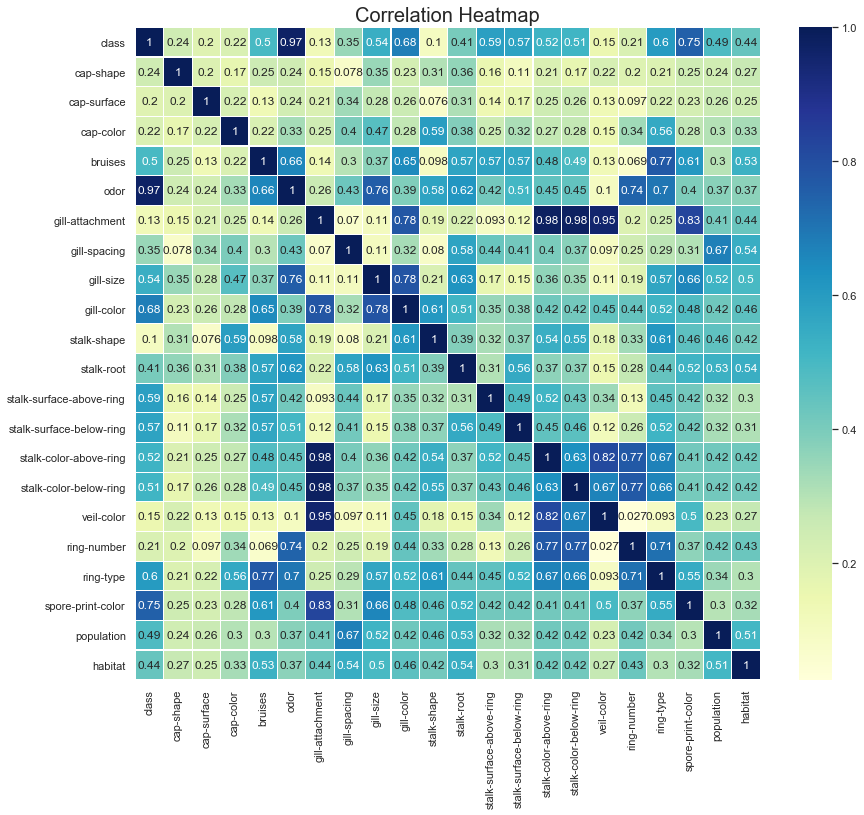

In [12]:
plt.figure(figsize=(14,12))
sns.heatmap(c_matrix,linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0)
plt.title("Correlation Heatmap", fontsize=20)
plt.show()

 - The feature "gill-attachment" is stronly associated with "stalk-color-above-ring", "stalk-color-below-ring" and "veil-color". We can remove it because it is redundant.
 - The feature "odor" and the response variable are strongly correlated. Approcimately **97%** of the variation in the response variable can be explained by this single feature. We will conduct a detailed analysis on the "odor"
later.

In [13]:
df = df.drop(columns=["gill-attachment"])
df_labeled = df_labeled.drop(columns=["gill-attachment"])

---

#### Bar Plot:
  - Find the distribution of the feature "odor"

In [14]:
odor_0 = df[df['class'] == 'e']['odor']
odor_1 = df[df['class'] == 'p']['odor']

In [15]:
c0 = Counter(odor_0)
c1 = Counter(odor_1)
labels = df['odor'].unique()
x_0 = [c0[i] for i in labels]
x_1 = [c1[i] for i in labels]

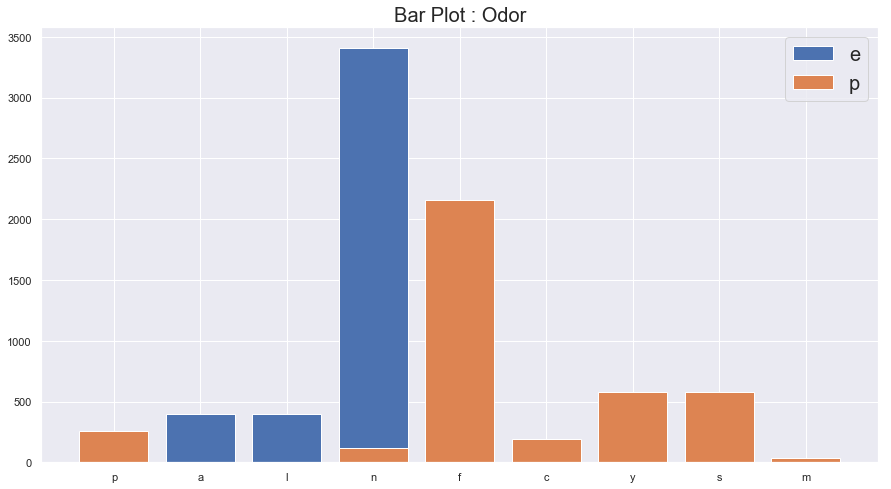

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(np.arange(0,len(labels)), x_0, label='e')
ax.bar(np.arange(0,len(labels)), x_1, label='p')
plt.xticks(range(0,9), list(labels))
ax.legend(prop={'size': 20})
plt.title("Bar Plot : Odor",fontsize=20)
plt.show()

In [17]:
# percentage of edible mushroom when the odor is 'n'
c0['n']/(c0['n'] + c1['n'])

0.9659863945578231

 - When the odor is 'p', 'f', 'c', 'y', 's', or 'm', the mushroom is poisonous.
 - When the odor is 'a' or 'l', the mushroom is edible.
 - 96.6% of the mushrooms having odor 'n' are edible.
 - However, the **odor** is very subjective. Cognitive bias might exist during the data collection process.
 
 ---

### Random Forest Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

In [19]:
X = df_labeled.values[:,1:]
y = df_labeled['class'].values

In [20]:
tree = DecisionTreeClassifier().fit(X,y)

### Holdout Cross Validation

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

In [22]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [23]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1684
           1       1.00      1.00      1.00      1566

   micro avg       1.00      1.00      1.00      3250
   macro avg       1.00      1.00      1.00      3250
weighted avg       1.00      1.00      1.00      3250



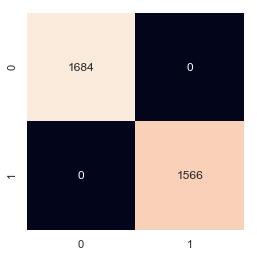

In [24]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.show()

### 5-fold Cross Validation

In [25]:
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = RandomForestClassifier(n_estimators=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       861
           1       1.00      1.00      1.00       764

   micro avg       1.00      1.00      1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       823
           1       1.00      1.00      1.00       802

   micro avg       1.00      1.00      1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       852
           1       1.00      1.00      1.00       773

   micro avg       1.00      1.00      1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              preci